# Visualise GRACE data:

In [2]:
from grace.base import GraphAttrs
from grace.io import read_graph
from grace.io.image_dataset import ImageGraphDataset, generate_ground_truth_graph

from grace.evaluation.visualisation import (
    display_image_and_grace_annotation, 
    read_patch_stack_by_label, 
    montage_from_image_patches, 
    overlay_from_image_patches,
    plot_simple_graph,
    plot_connected_components
)

import networkx as nx
import matplotlib.pyplot as plt


/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
grace_path = "/Users/kulicna/Desktop/dataset/shape_stars/infer"


In [4]:
dataset = ImageGraphDataset(image_dir=grace_path, grace_dir=grace_path)
dataset


In [5]:
image, graph_data = dataset[0]
graph = graph_data["graph"]
type(graph)


networkx.classes.graph.Graph

In [6]:
# Generate GT graph:

gt_graph = generate_ground_truth_graph(graph)
type(gt_graph)

networkx.classes.graph.Graph

### Display the annotation:

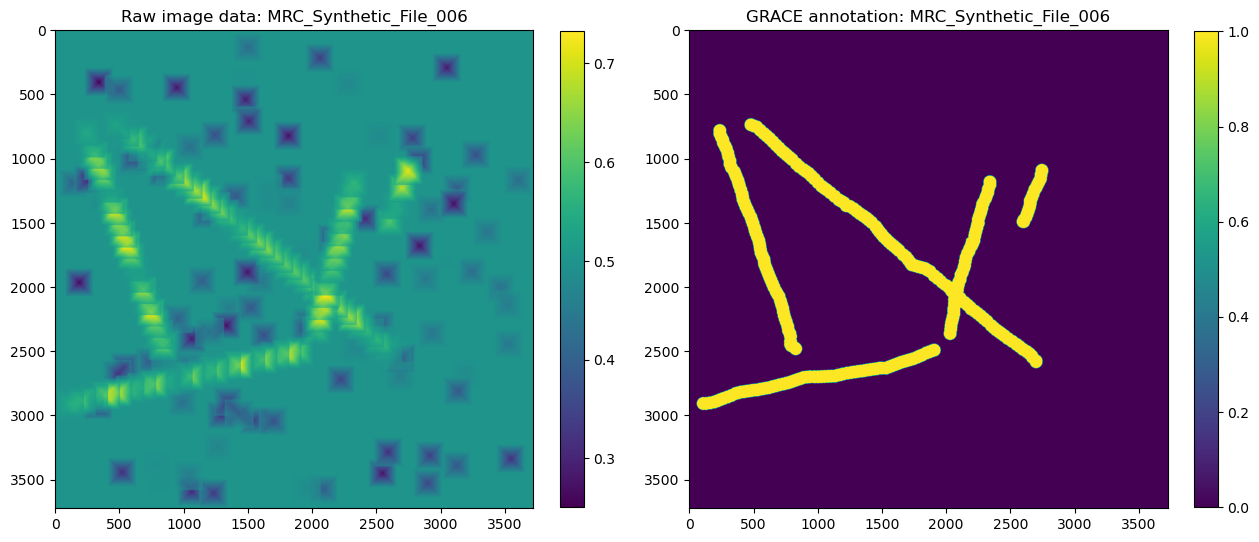

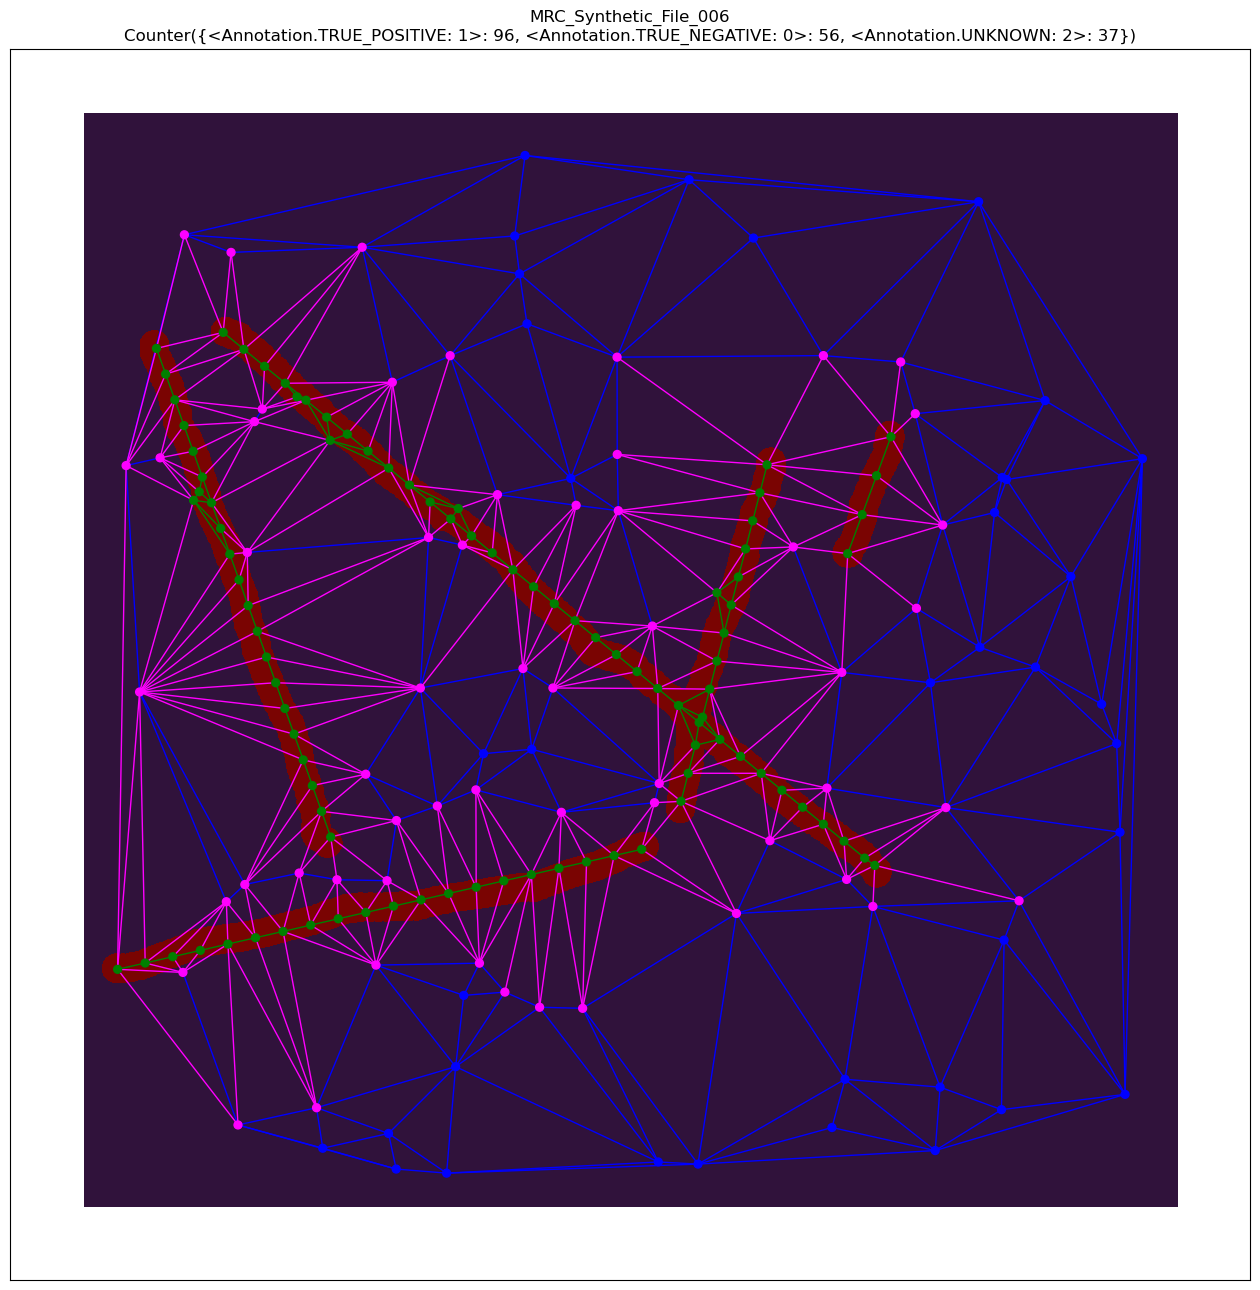

In [12]:
display_image_and_grace_annotation(image=image, target=graph_data)

In [13]:
crops = read_patch_stack_by_label(G=graph_data["graph"], image=image, crop_shape=(224, 224))
[len(c) for c in crops]

[56, 96, 37]

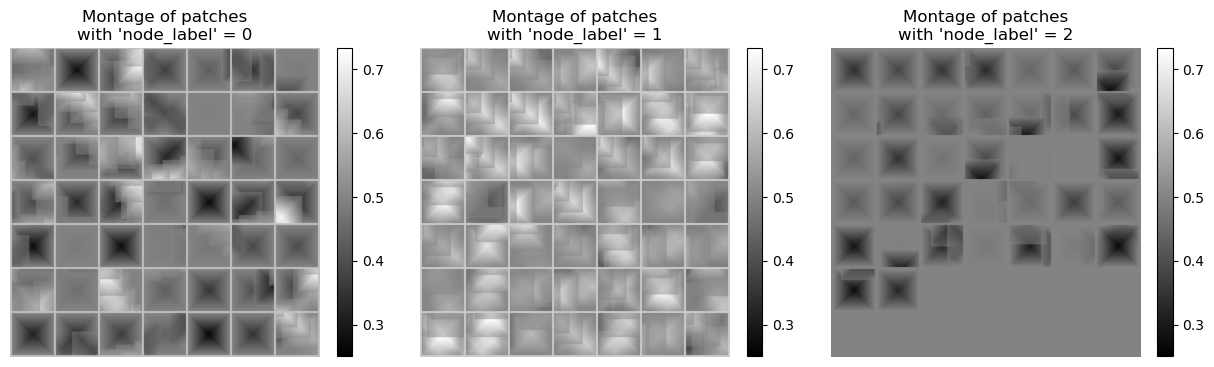

In [14]:
montage_from_image_patches(crops)

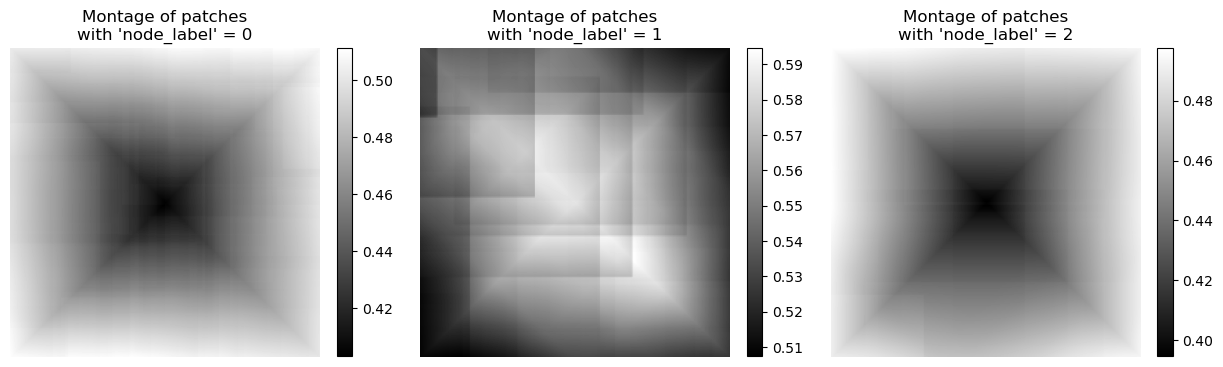

In [15]:
overlay_from_image_patches(crops)

### Draw the plain graphs:

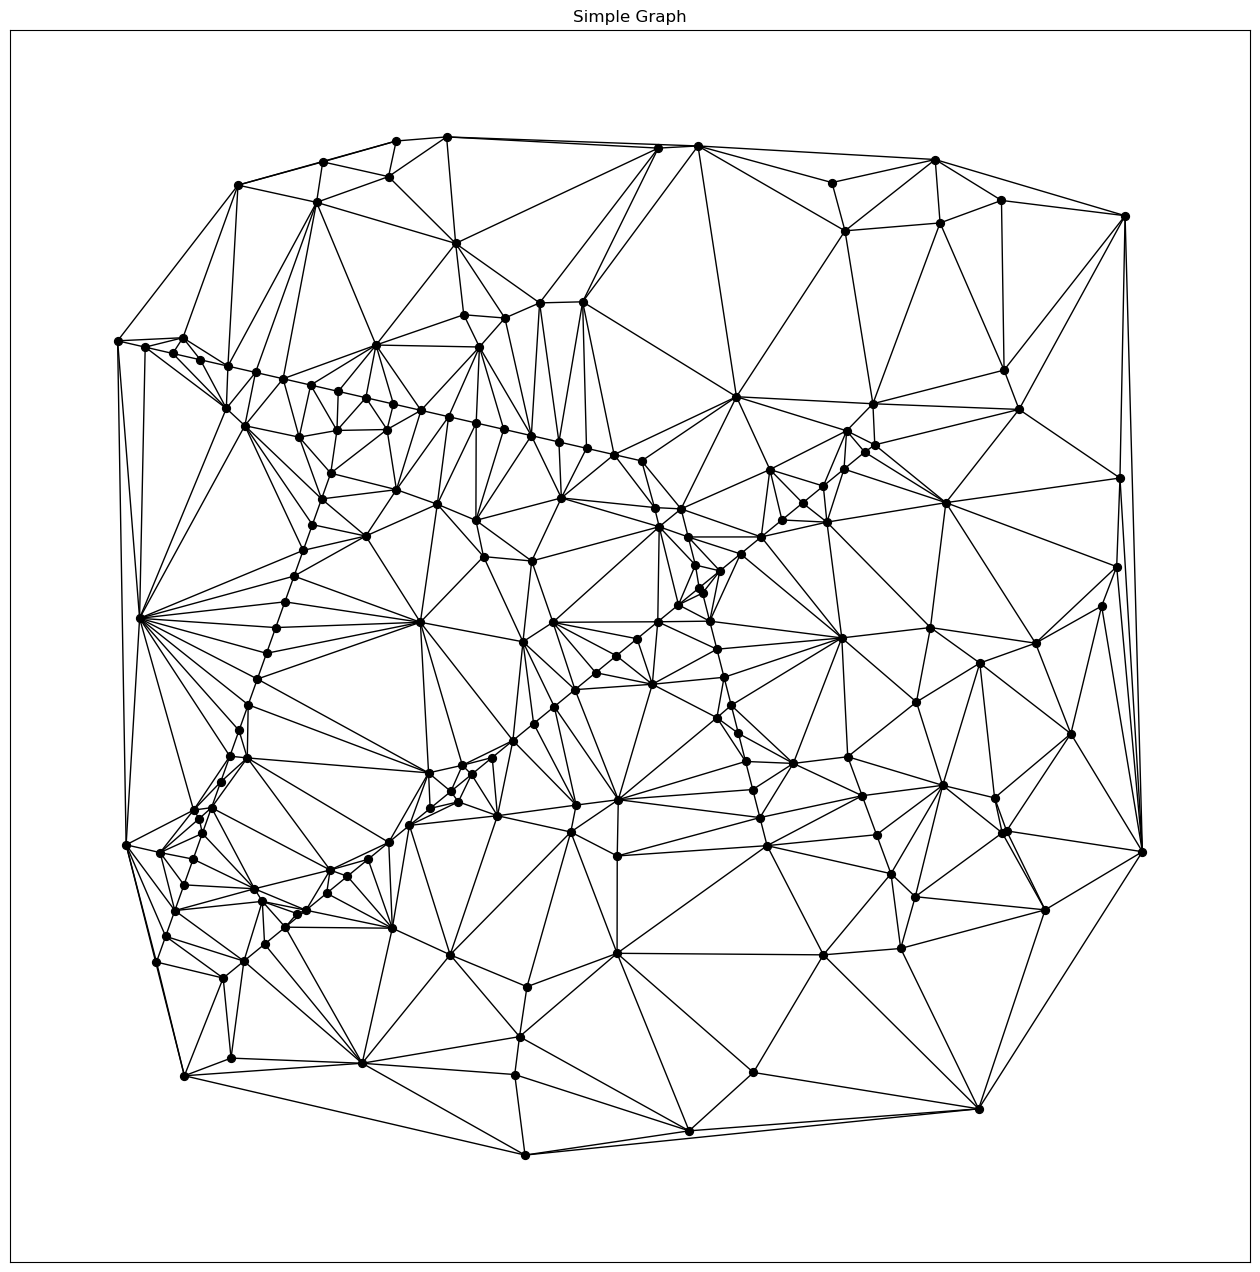

In [16]:
plot_simple_graph(G=graph, title="Simple Graph")

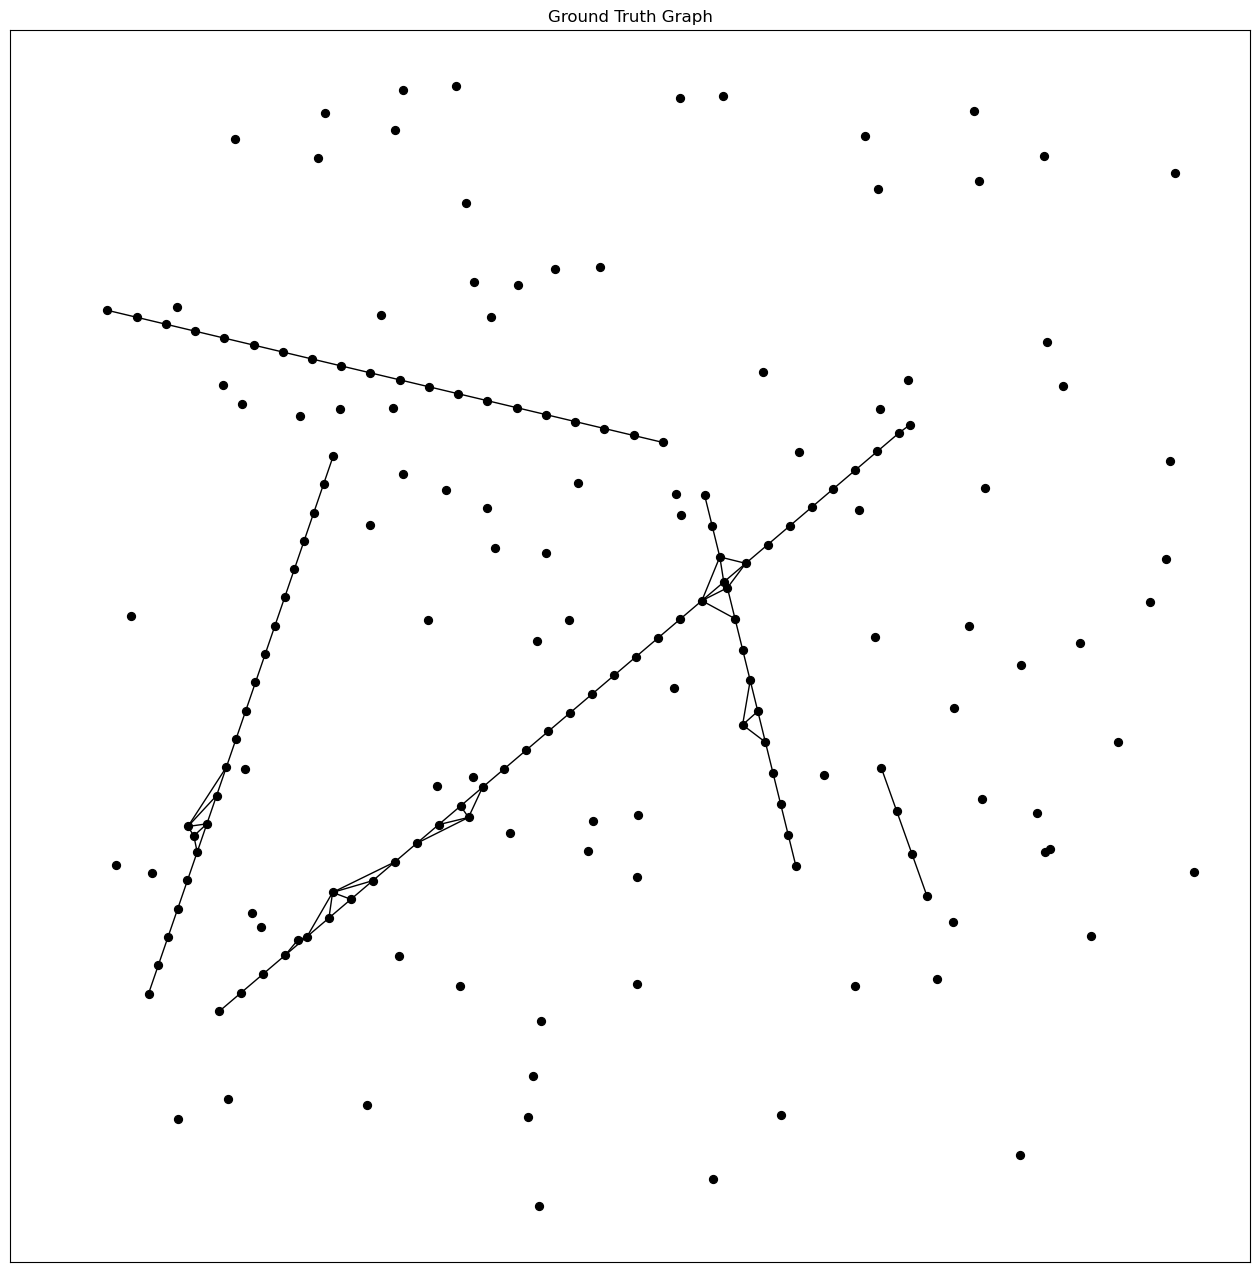

In [17]:
plot_simple_graph(G=gt_graph, title="Ground Truth Graph")

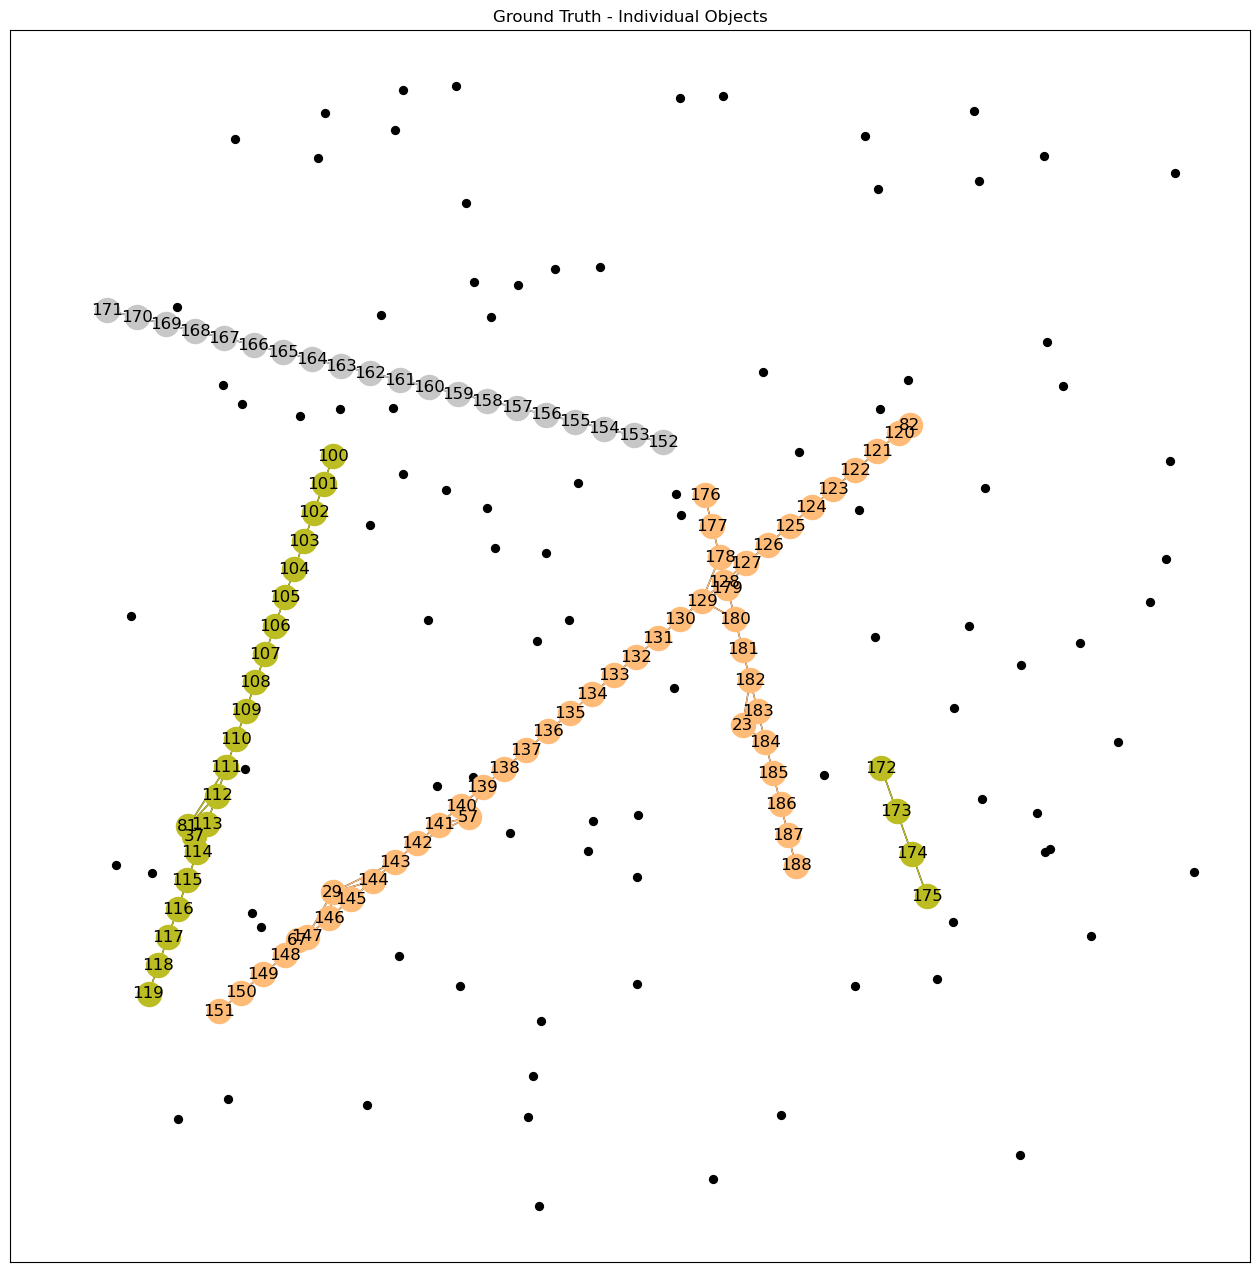

In [18]:
plot_connected_components(gt_graph, title="Ground Truth - Individual Objects")

##### Done!